# WGAN-GP EEG Generation: Normal vs Adaptive-D

This notebook loads the trained generators from your training run and generates samples from the **same random noises** for a fair, side-by-side comparison.

**Expected checkpoints (from your training notebook):**
- `./checkpoints_normal/best.pt`  (preferred)
- `./checkpoints_adaptive/best.pt` (preferred)

Fallbacks:
- `./generator_final_normal.pt`
- `./generator_final_adaptive.pt`

> If your files are in a different folder, change the paths in the **Load checkpoints** cell.

In [1]:
# Cell 1 — Imports & device
import os
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)


DEVICE: cuda


In [2]:
# Cell 2 — MUST MATCH training settings
# Update these if you changed them in the training notebook.
Z_DIM   = 100     # latent dim
SEQ_LEN = 256     # sequence length (must match training)
CHANNELS = 1      # EEG channel count (often 1)

# Generator width (must match training default 'base=64' unless you changed it)
GEN_BASE = 64


In [3]:
# Cell 3 — Generator definition (copied from training file)
def weights_init(m):
    if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d, nn.Linear)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

class Generator1D(nn.Module):
    def __init__(self, z_dim: int, out_channels: int, seq_len: int, base: int = 64):
        super().__init__()
        assert seq_len % 16 == 0
        self.init_len = seq_len // 16
        self.fc = nn.Linear(z_dim, base * 8 * self.init_len)
        self.net = nn.Sequential(
            nn.ConvTranspose1d(base * 8, base * 4, 4, 2, 1),
            nn.BatchNorm1d(base * 4),
            nn.ReLU(True),

            nn.ConvTranspose1d(base * 4, base * 2, 4, 2, 1),
            nn.BatchNorm1d(base * 2),
            nn.ReLU(True),

            nn.ConvTranspose1d(base * 2, base, 4, 2, 1),
            nn.BatchNorm1d(base),
            nn.ReLU(True),

            nn.ConvTranspose1d(base, out_channels, 4, 2, 1),
            nn.Tanh(),
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(z.size(0), -1, self.init_len)  # [B, base*8, seq_len/16]
        return self.net(x)                        # [B, C, seq_len]


In [4]:
# Cell 4 (REPLACE ENTIRE CELL)

import os
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def infer_G_hparams_from_state_dict(G_sd: dict):
    # z_dim from fc.weight: [base*8*init_len, z_dim]
    z_dim = G_sd["fc.weight"].shape[1]

    # out_channels from final ConvTranspose1d bias (your error showed net.9.bias)
    # fallback: find any ".bias" shaped like channels at the last convT
    if "net.9.bias" in G_sd:
        out_channels = G_sd["net.9.bias"].shape[0]
        last_bias_key = "net.9.bias"
    else:
        # find the last bias in net.*.bias
        bias_keys = [k for k in G_sd.keys() if k.startswith("net.") and k.endswith(".bias")]
        bias_keys_sorted = sorted(bias_keys, key=lambda x: int(x.split(".")[1]))
        last_bias_key = bias_keys_sorted[-1]
        out_channels = G_sd[last_bias_key].shape[0]

    # base from first ConvTranspose1d weight: shape [in_channels, out_channels, k]
    # in_channels = base*8
    if "net.0.weight" in G_sd:
        base8 = G_sd["net.0.weight"].shape[0]
    else:
        # find first convtranspose weight in net.*.weight
        w_keys = [k for k in G_sd.keys() if k.startswith("net.") and k.endswith(".weight")]
        w_keys_sorted = sorted(w_keys, key=lambda x: int(x.split(".")[1]))
        base8 = G_sd[w_keys_sorted[0]].shape[0]
    base = base8 // 8

    # init_len from fc.weight rows: base*8*init_len
    init_len = G_sd["fc.weight"].shape[0] // (base * 8)

    # seq_len is 16 * init_len (per your Generator1D definition)
    seq_len = init_len * 16

    return dict(z_dim=z_dim, out_channels=out_channels, seq_len=seq_len, base=base, init_len=init_len, last_bias_key=last_bias_key)

def load_generator_for_run(run_name: str, best: str, fallback: str):
    # choose checkpoint path
    source = best if os.path.exists(best) else fallback
    if not os.path.exists(source):
        raise FileNotFoundError(
            f"[{run_name}] Couldn't find checkpoint.\nTried:\n- {best}\n- {fallback}"
        )

    payload = torch.load(source, map_location="cpu")

    # training notebook saves {"G": state_dict, ...} (most likely)
    if isinstance(payload, dict) and "G" in payload:
        G_sd = payload["G"]
    # or it may directly be a state_dict
    elif isinstance(payload, dict) and "fc.weight" in payload:
        G_sd = payload
    else:
        raise ValueError(f"[{run_name}] Checkpoint format not recognized at: {source}")

    hp = infer_G_hparams_from_state_dict(G_sd)
    print(f"[{run_name}] inferred hparams:", hp)

    # IMPORTANT: build the exact same architecture
    G = Generator1D(hp["z_dim"], hp["out_channels"], hp["seq_len"], base=hp["base"]).to(device)
    G.load_state_dict(G_sd, strict=True)
    G.eval()

    print(f"[{run_name}] Loaded generator from: {source}")
    return G, hp

G_normal, hp_normal = load_generator_for_run(
    "normal",
    "./checkpoints_normal/best.pt",
    "./generator_final_normal.pt"
)

G_adapt, hp_adapt = load_generator_for_run(
    "adaptive",
    "./checkpoints_adaptive/best.pt",
    "./generator_final_adaptive.pt"
)

# sanity: make sure both runs are compatible for side-by-side generation
assert hp_normal["z_dim"] == hp_adapt["z_dim"], "z_dim differs between normal and adaptive checkpoints"
assert hp_normal["out_channels"] == hp_adapt["out_channels"], "out_channels differs between checkpoints"
assert hp_normal["seq_len"] == hp_adapt["seq_len"], "seq_len differs between checkpoints"

Z_DIM = hp_normal["z_dim"]
CHANNELS = hp_normal["out_channels"]
SEQ_LEN = hp_normal["seq_len"]

print("Using:", {"Z_DIM": Z_DIM, "CHANNELS": CHANNELS, "SEQ_LEN": SEQ_LEN})

[normal] inferred hparams: {'z_dim': 128, 'out_channels': 6, 'seq_len': 1024, 'base': 64, 'init_len': 64, 'last_bias_key': 'net.9.bias'}
[normal] Loaded generator from: ./checkpoints_normal/best.pt
[adaptive] inferred hparams: {'z_dim': 128, 'out_channels': 6, 'seq_len': 1024, 'base': 64, 'init_len': 64, 'last_bias_key': 'net.9.bias'}
[adaptive] Loaded generator from: ./checkpoints_adaptive/best.pt
Using: {'Z_DIM': 128, 'CHANNELS': 6, 'SEQ_LEN': 1024}


In [5]:
# Cell 5 — Generate from the SAME random noises (fair comparison)
torch.manual_seed(123)
np.random.seed(123)

N_SAMPLES = 12          # how many waveforms to generate
Z_FIXED = torch.randn(N_SAMPLES, Z_DIM, device=DEVICE)

@torch.no_grad()
def gen(G, z):
    x = G(z).detach().cpu().numpy()
    # shape: [B, C, T] -> squeeze channel if C==1
    if x.shape[1] == 1:
        x = x[:, 0, :]
    return x

x_normal = gen(G_normal, Z_FIXED)
x_adapt  = gen(G_adapt,  Z_FIXED)

print("x_normal:", x_normal.shape, "x_adapt:", x_adapt.shape)


x_normal: (12, 6, 1024) x_adapt: (12, 6, 1024)


In [6]:
# Cell 5.5 — Load REAL evaluation (E) windows (saved from training notebook)
import numpy as np

E_NPY_PATH = "./X_eval_E.npy"   # must exist in the same folder you run the notebook from
X_eval = np.load(E_NPY_PATH)    # shape: (N_E, C, T)

print("Loaded X_eval:", X_eval.shape)

# Pick the same number of real samples as generated
rng = np.random.default_rng(123)
idx = rng.choice(X_eval.shape[0], size=N_SAMPLES, replace=False)
x_real = X_eval[idx]            # shape: (N_SAMPLES, C, T)

print("x_real:", x_real.shape)

Loaded X_eval: (8236, 6, 1024)
x_real: (12, 6, 1024)


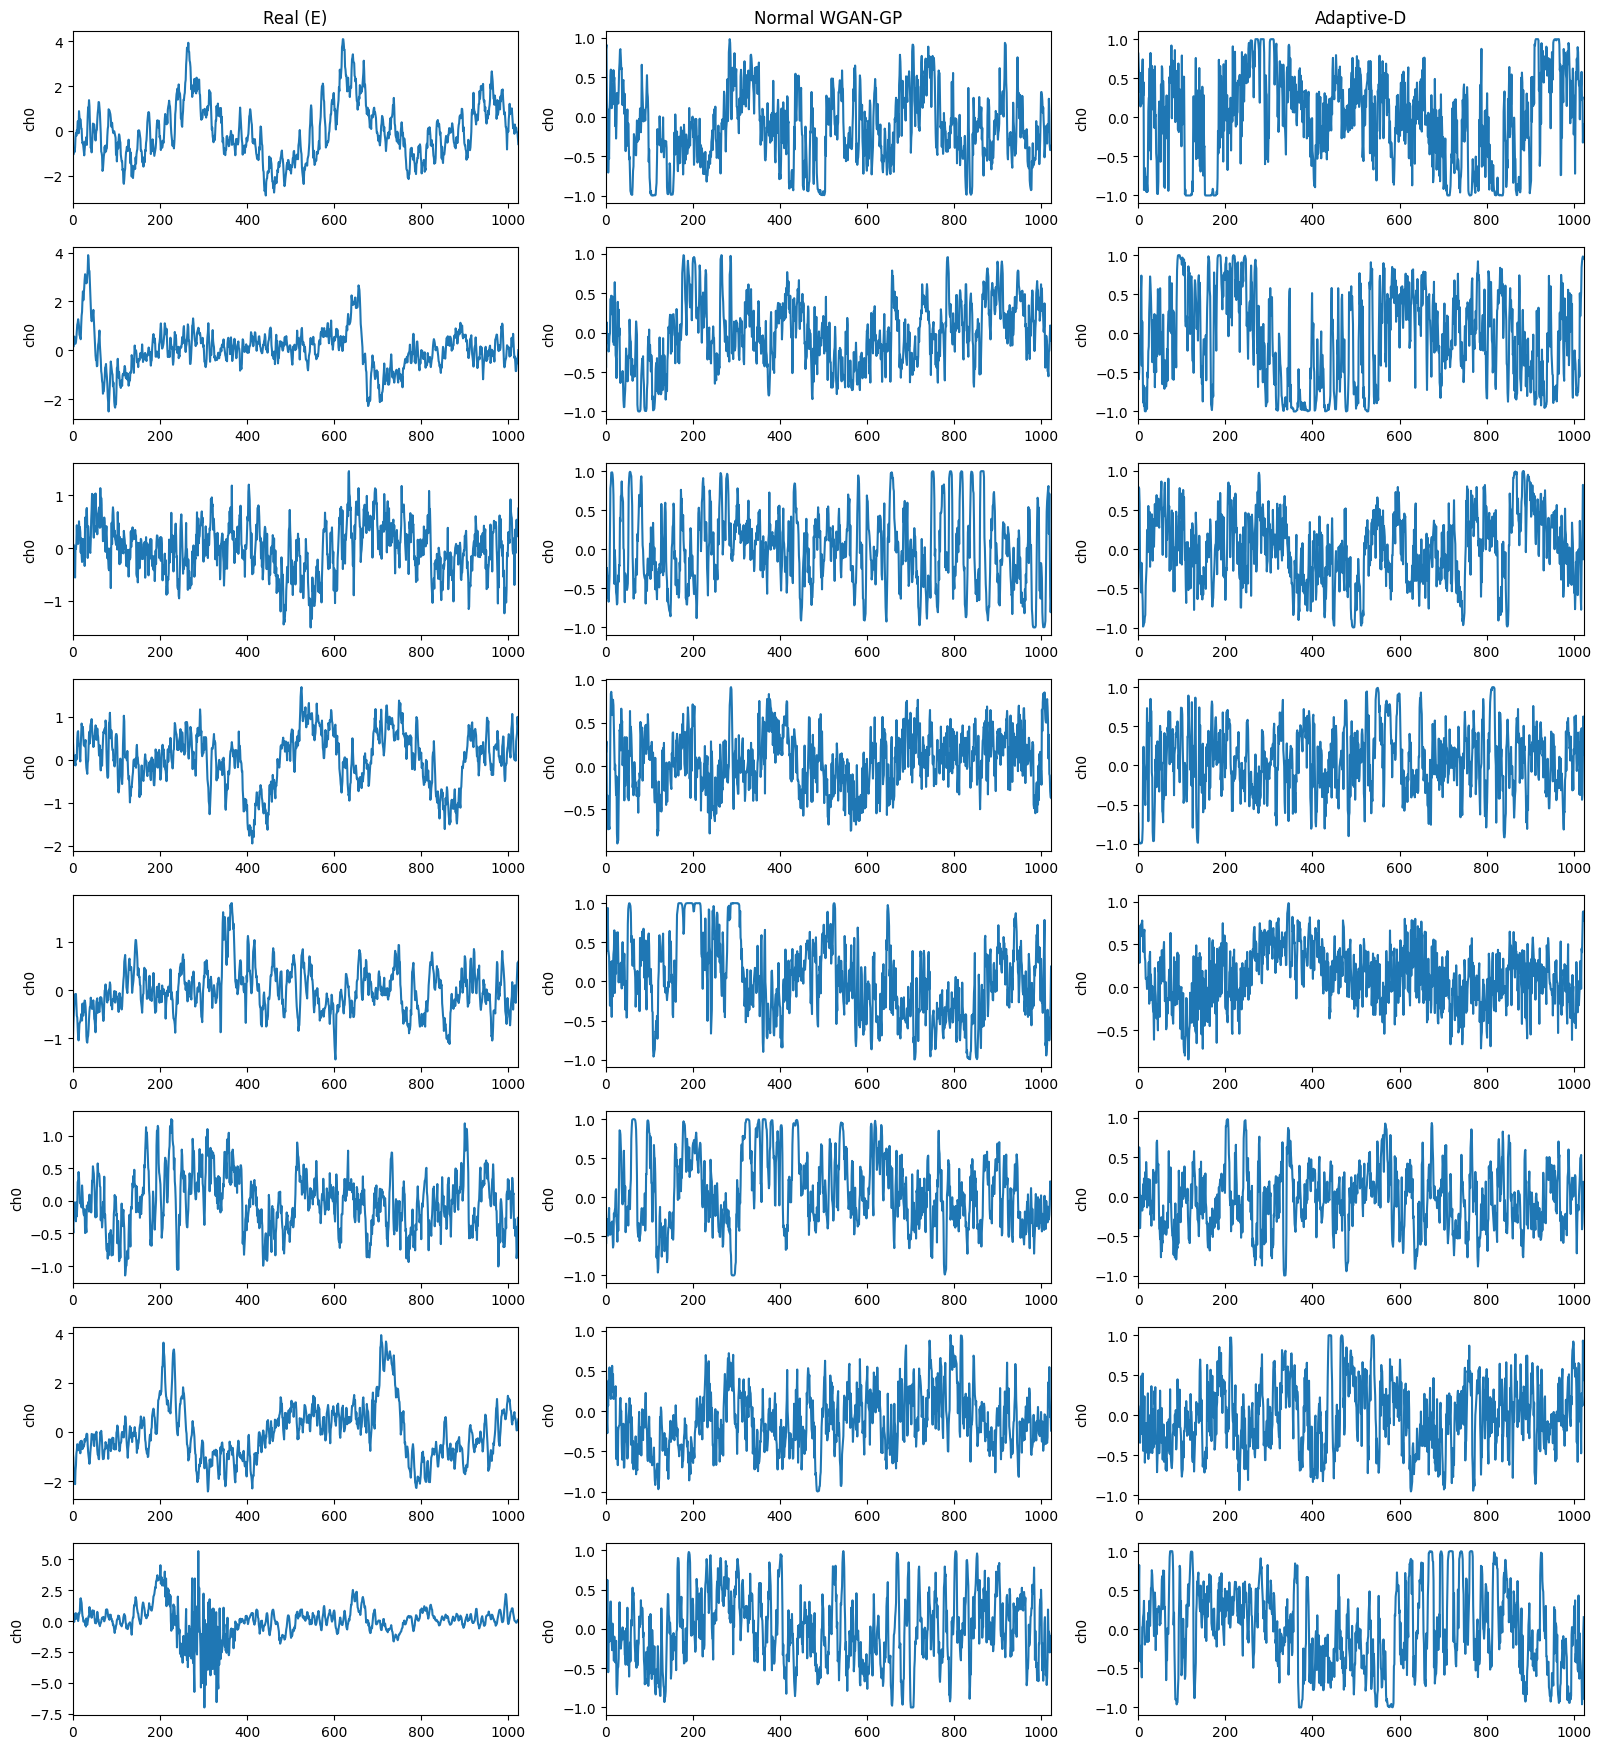

In [7]:
# Cell 6 (REPLACE) — Real(E) vs Normal vs Adaptive side-by-side (multi-channel)

import numpy as np
import matplotlib.pyplot as plt

def to_ncl(x):
    x = np.asarray(x)
    if x.ndim == 2:   # (N, T) -> (N, 1, T)
        x = x[:, None, :]
    return x

x_real_ncl  = to_ncl(x_real)
x_norm_ncl  = to_ncl(x_normal)
x_adpt_ncl  = to_ncl(x_adapt)

# Use minimum count just in case
N_SHOW = min(8, x_real_ncl.shape[0], x_norm_ncl.shape[0], x_adpt_ncl.shape[0])
C = x_real_ncl.shape[1]
T_len = x_real_ncl.shape[2]
T = np.arange(T_len)

MODE = "ch0"   # options: "ch0", "mean", "all"
rows = N_SHOW
cols = 3

plt.figure(figsize=(16, 2.2 * rows))

for i in range(N_SHOW):
    # ---- Real (E) ----
    ax0 = plt.subplot(rows, cols, i * cols + 1)
    if MODE == "ch0":
        ax0.plot(T, x_real_ncl[i, 0, :]); ax0.set_ylabel("ch0")
    elif MODE == "mean":
        ax0.plot(T, x_real_ncl[i].mean(axis=0)); ax0.set_ylabel("mean(C)")
    elif MODE == "all":
        for c in range(C): ax0.plot(T, x_real_ncl[i, c, :])
        ax0.set_ylabel("all ch")
    if i == 0: ax0.set_title("Real (E)")
    ax0.set_xlim(0, T_len - 1)

    # ---- Normal ----
    ax1 = plt.subplot(rows, cols, i * cols + 2)
    if MODE == "ch0":
        ax1.plot(T, x_norm_ncl[i, 0, :]); ax1.set_ylabel("ch0")
    elif MODE == "mean":
        ax1.plot(T, x_norm_ncl[i].mean(axis=0)); ax1.set_ylabel("mean(C)")
    elif MODE == "all":
        for c in range(C): ax1.plot(T, x_norm_ncl[i, c, :])
        ax1.set_ylabel("all ch")
    if i == 0: ax1.set_title("Normal WGAN-GP")
    ax1.set_xlim(0, T_len - 1)

    # ---- Adaptive ----
    ax2 = plt.subplot(rows, cols, i * cols + 3)
    if MODE == "ch0":
        ax2.plot(T, x_adpt_ncl[i, 0, :]); ax2.set_ylabel("ch0")
    elif MODE == "mean":
        ax2.plot(T, x_adpt_ncl[i].mean(axis=0)); ax2.set_ylabel("mean(C)")
    elif MODE == "all":
        for c in range(C): ax2.plot(T, x_adpt_ncl[i, c, :])
        ax2.set_ylabel("all ch")
    if i == 0: ax2.set_title("Adaptive-D")
    ax2.set_xlim(0, T_len - 1)

plt.tight_layout()
plt.show()

In [8]:
# Cell 7 — Quick numeric comparison (optional sanity checks)
def summarize(x, name):
    # x: [B, T]
    mean_per_sample = x.mean(axis=1)
    std_per_sample  = x.std(axis=1)
    print(f"{name}: mean(mean)={mean_per_sample.mean():+.4f} | mean(std)={std_per_sample.mean():.4f} | "
          f"min={x.min():+.4f} | max={x.max():+.4f}")

summarize(x_normal, "Normal")
summarize(x_adapt,  "Adaptive")


Normal: mean(mean)=-0.0071 | mean(std)=0.2996 | min=-1.0000 | max=+1.0000
Adaptive: mean(mean)=+0.0167 | mean(std)=0.3244 | min=-1.0000 | max=+1.0000


In [9]:
# Cell 8 — Save generated arrays + the fixed noises (for reproducibility)
out_dir = Path("./generated_compare")
out_dir.mkdir(parents=True, exist_ok=True)

np.save(out_dir / "z_fixed.npy", Z_FIXED.detach().cpu().numpy())
np.save(out_dir / "gen_normal.npy", x_normal)
np.save(out_dir / "gen_adaptive.npy", x_adapt)

print("Saved to:", out_dir.resolve())


Saved to: /home/glider/gans_eeg/gradient_norm/generated_compare
